In [1]:
"""
# 전처리 배분

1(성준) - 0~9,   40~49, 80~89, 120, 
       - credit_card_balance.csv
       - POS_CASH_balance.csv
       - previous_application.csv
       - installments_payments.csv
2(장호) - 10~19, 50~59, 90~99, 121
3(두영) - 20~29, 60~69, 100~109, 122, 
       - bureau.csv,
4(혜빈) - 30~39, 70~79, 110~119, 123, 
       - bureau_balance.csv
5(준혁) -  
"""

"""
# 데이터 목록
application_test.csv
application_train.csv
credit_card_balance.csv
POS_CASH_balance.csv
previous_application.csv
installments_payments.csv
bureau.csv
bureau_balance.csv
sample_submission.csv
"""

'\n# 데이터 목록\napplication_test.csv\napplication_train.csv\ncredit_card_balance.csv\nPOS_CASH_balance.csv\nprevious_application.csv\ninstallments_payments.csv\nbureau.csv\nbureau_balance.csv\nsample_submission.csv\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
import user_functions as uf

import platform
import matplotlib
%matplotlib inline
# 한글 출력되게 설정
uf.korean2()

## previous_application.csv
---

- <span style="color:red">ID 값 중복 존재함</span>
- <span style="color:red">`NAME_CONTRACT_TYPE`에 따라 값이 구분됨</span>

In [3]:
prev_app = pd.read_csv(uf.get_f_path()+"previous_application.csv")

In [4]:
# NAME_CONTRACT_STATUS가 취소된 것 제거함
uf.drop_v_i(prev_app, "NAME_CONTRACT_STATUS", ["Canceled", "Unused offer"])

# 승인/거부 여부를 1(승인), -1(거부)로 한 feature 생성
prev_app["승인/거부(prev_app)"] = prev_app.loc[:, "NAME_CONTRACT_STATUS"]
prev_app["승인/거부(prev_app)"] = \
    prev_app["승인/거부(prev_app)"].apply(lambda x: 1 if x == "Approved" else -1)

# NAME_CONTRACT_STATUS feature 삭제
prev_app.drop(columns="NAME_CONTRACT_STATUS", inplace=True)

# AMT_CREDIT 결측값 1개 삭제
prev_app.drop(prev_app.loc[prev_app["AMT_CREDIT"].isna()].index, inplace=True)

# CNT_PAYMENT가 결측인데 대출 승인된 값을 삭제함
# prev_app.loc[prev_app["CNT_PAYMENT"].isna(), "승인/거부(prev_app)"].value_counts()
prev_app.drop(prev_app.loc[(prev_app["CNT_PAYMENT"].isna()) & 
                           (prev_app["승인/거부(prev_app)"] == 1)].index, 
              inplace=True
             )

# AMT_ANNUITY 결측인데 대출 승인된 값을 삭제함
# prev_app.loc[prev_app["AMT_ANNUITY"].isna(), "승인/거부(prev_app)"].value_counts()
prev_app.drop(prev_app.loc[(prev_app["AMT_ANNUITY"].isna()) & 
                           (prev_app["승인/거부(prev_app)"] == 1)].index, 
              inplace=True
             )

# AMT_CREDIT이 0인데 대출 승인된 값을 삭제함
# prev_app.loc[(prev_app["AMT_CREDIT"] == 0) & (prev_app["승인/거부(prev_app)"] == 1)]
prev_app.drop(prev_app.loc[(prev_app["AMT_CREDIT"] == 0) & 
                           (prev_app["승인/거부(prev_app)"] == 1)].index, 
              inplace=True
             )

# AMT_ANNUITY가 0인데 대출 승인된 값을 삭제함
# prev_app.loc[(prev_app["AMT_ANNUITY"] == 0) & (prev_app["승인/거부(prev_app)"] == 1)]
prev_app.drop(prev_app.loc[(prev_app["AMT_ANNUITY"] == 0) & 
                           (prev_app["승인/거부(prev_app)"] == 1)].index, 
              inplace=True
             )

# AMT_APPLICATION(신청액)이 0인데 대출 승인된 값을 삭제함
prev_app.drop(prev_app.loc[(prev_app["AMT_APPLICATION"] == 0) & 
                           (prev_app["승인/거부(prev_app)"] == 1)].index, 
              inplace=True
             )

# CNT_PAYMENT(대출 기간)이 결측치인데 대출이 승인된 값을 삭제함
prev_app.drop(prev_app.loc[(prev_app["CNT_PAYMENT"].isna()) & 
                           (prev_app["승인/거부(prev_app)"] == 1)].index, 
              inplace=True
             )

# AMT_GOODS_PRICE(상품 금액)과 AMT_CREDIT(대출액)이 같은데 AMT_DOWN_PAYMENT가 결측이면 AMT_DOWN_PAYMENT를 0으로 대치함
prev_app.drop(prev_app.loc[(prev_app["AMT_GOODS_PRICE"] == prev_app["AMT_CREDIT"]) & 
                           (prev_app["AMT_DOWN_PAYMENT"].isna())].index, 
              inplace=True
             )

# AMT_CREDIT(대출액)이 AMT_GOODS_PRICE(상품금액)보다 크고 AMT_DOWN_PAYMENT가 결측이면 AMT_DOWN_PAYMENT를 0으로 대치함
prev_app.drop(prev_app.loc[(prev_app["AMT_CREDIT"] > prev_app["AMT_GOODS_PRICE"]) & 
                           (prev_app["AMT_DOWN_PAYMENT"].isna())].index, 
              inplace=True
             )

# CNT_PAYMENT가 0인데 대출 승인된 값을 삭제함
prev_app.drop(prev_app.loc[(prev_app["CNT_PAYMENT"] == 0) & 
                           (prev_app["승인/거부(prev_app)"] == 1)].index, 
              inplace=True
             )

# 대출 승인되었으나, AMT_DOWN_PAYMENT가 결측이면 0으로 대치함
prev_app.loc[(prev_app["AMT_DOWN_PAYMENT"].isna())
              & (prev_app["승인/거부(prev_app)"] == 1), "AMT_DOWN_PAYMENT"] = 0


# print(prev_app["NAME_CONTRACT_TYPE"].unique())
# NAME_CONTRACT_TYPE가 XNA 값이면 의미있는 값이 없음
# print(prev_app[prev_app["NAME_CONTRACT_TYPE"] == "XNA"].iloc[1])

# NAME_CONTRACT_TYPE 값에 맞춰 각각의 Datasets 생성
for value_ in prev_app["NAME_CONTRACT_TYPE"].unique():
    string = value_.lower().replace(" ", "_")
    if string != "xna":
        globals()["ds_%s" %(string)] = \
            prev_app.loc[prev_app["NAME_CONTRACT_TYPE"] == value_]

# ds_consumer_loans
# ds_cash_loans
# ds_revolving_loans

In [5]:
# 이자율 = (24 * 총이자액) / (원금 * (m+1))
def interest_rate(principal, total_interest, m):
    """
    principal = 원금  
    total_interest = 이자 총액  
    m = 상환기간(월)
    """
    i_rate = (24 * total_interest) / (principal * (m + 1))
    return i_rate

In [6]:
prev_app["(추정)이자율"] = \
    interest_rate(prev_app["AMT_CREDIT"],
                  (prev_app["AMT_ANNUITY"] * prev_app["CNT_PAYMENT"]) \
                    - prev_app["AMT_CREDIT"],
                  prev_app["CNT_PAYMENT"]
                )
# 승인이 거부된 이자율은 -1로 설정
prev_app.loc[prev_app["승인/거부(prev_app)"] == -1, "(추정)이자율"] = 0

In [7]:
# DAYS_LAST_DUE(실제 상환일) - DAYS_LAST_DUE_1ST_VERSION(계약 상 상환일)
## +가 연체일
prev_app["연체일"] = prev_app["DAYS_LAST_DUE"] - prev_app["DAYS_LAST_DUE_1ST_VERSION"]
# DAYS_LAST_DUE_1ST_VERSION(계약 상 상환일)이 양수(+)이면 계약이 완료된 것이 아님
## 따라서 0으로 처리함
prev_app.loc[prev_app["DAYS_LAST_DUE_1ST_VERSION"] >= 0, "연체일"] = 0 

# "연체일"일 0보다 작으면 조기상환한 것임 -> 따라서 0으로 처리함
prev_app.loc[prev_app["연체일"] < 0, "연체일"] = 0 

# DAYS_LAST_DUE(실제 상환일) 값이 365243.0인 것은 현재 연체가 진행 중이라는 의미
## prev_app.loc[prev_app["연체일"] > 30000, "DAYS_LAST_DUE_1ST_VERSION"].hist()
## 즉 연체일을 정확히 알 수 없음. 
## 따라서 정상 연체값 중 max값을 연체일 값으로 주되, 현재 연체일이 정상 연체값 중 max보다 크면 그 값을 선택하고 가중치를 2배로 한다.
## 예컨대 정상 연체값 중 최대값은 40일이나, 현재 연체일이 50일 지난 경우 연체값은 그 값의 2배로 가중하여 100을 할당한다.
temp_max = \
    prev_app.loc[(prev_app["연체일"] > 0) & (prev_app["연체일"] < 30000), "연체일"].max()
prev_app.loc[(prev_app["연체일"] > 30000) & \
                (prev_app["DAYS_LAST_DUE_1ST_VERSION"] < -(temp_max)),
             "연체일"
             ] = prev_app["DAYS_LAST_DUE_1ST_VERSION"] * -2
prev_app.loc[(prev_app["연체일"] > 30000), "연체일"] = temp_max

In [8]:
# 계약이 승인되었으나, DAYS_FIRST_DUE 값도 없는 관측치가 9,470개에 달함
## DAYS_DECISION(계약일)이 -1,000을 넘어가는 값도 많아 
## 1. 악성 연체자로 판단하거나 
## 2. 어떠한 이유로 계약이 실행되지 않은 것으로 판단해야 함.
## 우선 첫번째 상환도 하지 않은 악성 연체자로 판단하여 DAYS_DECISION 값을 365로 설정함.
## 이전 연체일 max = 178일
# prev_app.loc[(prev_app["연체일"].isna()) &
#              (prev_app["승인/거부(prev_app)"] == 1) &
#              (prev_app["DAYS_DECISION"] < prev_app["CNT_PAYMENT"] * -30)
#              , "DAYS_DECISION"].hist()

prev_app.loc[(prev_app["연체일"].isna()) &
             (prev_app["승인/거부(prev_app)"] == 1) &
             (prev_app["DAYS_DECISION"] < prev_app["CNT_PAYMENT"] * -30)
             , "연체일"] = 365

# DAYS_DECISION(계약일)이 CNT_PAYMENT(계약기간) 이내이나, 첫 번째 대금을 납입하지 않은 경우 연체로 판단함
# 단, max를 365로 제한함.
prev_app.loc[(prev_app["연체일"].isna()) & \
                (prev_app["승인/거부(prev_app)"] == 1) & \
                (prev_app["DAYS_DECISION"] >= prev_app["CNT_PAYMENT"] * -30),
             "연체일"
            ] = (prev_app["DAYS_DECISION"] * -1).apply(lambda x: 365 if x > 365 else x)

In [9]:
# 승인이 거부된 연체일은 -1로 설정
prev_app.loc[prev_app["연체일"].isna(), "연체일"] = 0

# 연체(1), 연체X(-1)
prev_app["연체여부"] = prev_app["연체일"].apply(lambda x: 1 if x > 0 else 0)

<AxesSubplot:>

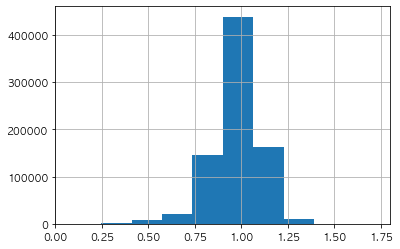

In [10]:
# 대출 승인 비율
prev_app["승인액/요청액"] = prev_app["AMT_CREDIT"] / prev_app["AMT_APPLICATION"] 
# 대출 승인이 거부된 경우 승인액/요청액은 1
prev_app.loc[prev_app["승인/거부(prev_app)"] == -1, "승인액/요청액"] = 1
prev_app["승인액/요청액"].hist()

In [11]:
# # 제품가격 대비 승인액 비율
# prev_app["승인액/제품가격"] = prev_app["AMT_CREDIT"] / prev_app["AMT_GOODS_PRICE"] 
# # 대출 승인이 거부된 경우 승인액/요청액은 -1
# prev_app.loc[prev_app["승인/거부(prev_app)"] == -1, "승인액/제품가격"] = -1
# prev_app["승인액/제품가격"].hist()
# # 상관관계가 매우 높으므로 사용하지 않음.
# uf.corr_heatmap(prev_app[["승인액/제품가격", "승인액/요청액"]])

In [12]:
group_ds = prev_app[['SK_ID_CURR', '승인/거부(prev_app)', \
                     '(추정)이자율', '연체일', '연체여부', '승인액/요청액']
                   ]

In [16]:
agg_set = {"승인/거부(prev_app)": np.sum,
           "(추정)이자율": np.max,
           "연체일": np.sum,
           "연체여부": np.sum,
           "승인액/요청액": np.mean}
fin_ds = group_ds.groupby("SK_ID_CURR").agg(agg_set)
fin_ds.rename(columns={"연체여부": "연체횟수"}, inplace=True)

In [17]:
# prev_app.loc[prev_app["SK_ID_CURR"] == 229226].head(50)
fin_ds

,승인/거부(prev_app),(추정)이자율,연체일,연체횟수,승인액/요청액
SK_ID_CURR,,,,,
100001,1,0.876781,0.0,0,0.957782
100002,1,0.230477,0.0,0,1.000000
100003,2,0.381257,0.0,0,1.011007
100004,1,0.315846,0.0,0,0.828021
100005,1,0.809428,0.0,0,0.899950
...,...,...,...,...,...
456251,1,0.816860,0.0,0,1.000000
456252,1,0.218748,0.0,0,0.986561
456253,2,0.765959,0.0,0,0.831397


In [18]:
# 결측값 확인
uf.check_missing_value(fin_ds)

# 저장
fin_ds.to_csv("../pre_data/new_previous_application.csv")

결측치 없음!
